In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
grid_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'compressed_shuffle_cancer_type',
    'gene'
).resolve()

bayes_opt_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'bayes_opt',
    'gene'
).resolve()

In [3]:
# load raw data
grid_results_df = au.load_stratified_prediction_results(grid_results_dir, 'gene')

# drop TET2 for now
grid_results_df = grid_results_df[~(grid_results_df.identifier == 'TET2')]
grid_results_df['param_opt'] = 'grid'

# make sure that we have data for all data types and for two replicates (random seeds)
print(grid_results_df.shape)
print(grid_results_df.seed.unique())
print(grid_results_df.identifier.unique())
print(grid_results_df.training_data.unique())
grid_results_df.head()

(1152, 10)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_450k' 'expression.me_27k' 'me_27k.me_450k'
 'expression.me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.94104,0.91808,TP53,expression.me_450k,signal,42,train,0,gene,grid
1,0.91608,0.88448,TP53,expression.me_450k,signal,42,test,0,gene,grid
2,0.86899,0.82254,TP53,expression.me_450k,signal,42,cv,0,gene,grid
3,0.94074,0.92014,TP53,expression.me_450k,signal,42,train,1,gene,grid
4,0.90890,0.87164,TP53,expression.me_450k,signal,42,test,1,gene,grid


In [4]:
group_df = (grid_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

group_df.head(30)

auroc  aupr  signal  seed  data_type  \
identifier training_data                                                     
EGFR       expression.me_27k             48    48      48    48         48   
           expression.me_27k.me_450k     48    48      48    48         48   
           expression.me_450k            48    48      48    48         48   
           me_27k.me_450k                48    48      48    48         48   
IDH1       expression.me_27k             48    48      48    48         48   
           expression.me_27k.me_450k     48    48      48    48         48   
           expression.me_450k            48    48      48    48         48   
           me_27k.me_450k                48    48      48    48         48   
KRAS       expression.me_27k             48    48      48    48         48   
           expression.me_27k.me_450k     48    48      48    48         48   
           expression.me_450k            48    48      48    48         48   
           me_27k.me_450k                48    48      48    48         48   
PIK3CA     expression.me_27k             48    48      48    48         48   
           expression.me_27k.me_450k     48    48      48    48         48   
           expression.me_450k            48    48      48    48         48   
           me_27k.me_450k                48    48      48    48         48   
SETD2      expression.me_27k             48    48      48    48         48   
           expression.me_27k.me_450k     48    48      48    48         48   
           expression.me_450k            48    48      48    48         48   
           me_27k.me_450k                48    48      48    48         48   
TP53       expression.me_27k             48    48      48    48         48   
           expression.me_27k.me_450k     48    48      48    48         48   
           expression.me_450k            48    48      48    48         48   
           me_27k.me_450k                48    48      48    48         48   

                                      fold  experiment  param_opt  
identifier training_data                                           
EGFR       expression.me_27k            48          48         48  
           expression.me_27k.me_450k    48          48         48  
           expression.me_450k           48          48         48  
           me_27k.me_450k               48          48         48  
IDH1       expression.me_27k            48          48         48  
           expression.me_27k.me_450k    48          48         48  
           expression.me_450k           48          48         48  
           me_27k.me_450k               48          48         48  
KRAS       expression.me_27k            48          48         48  
           expression.me_27k.me_450k    48          48         48  
           expression.me_450k           48          48         48  
           me_27k.me_450k               48          48         48  
PIK3CA     expression.me_27k            48          48         48  
           expression.me_27k.me_450k    48          48         48  
           expression.me_450k           48          48         48  
           me_27k.me_450k               48          48         48  
SETD2      expression.me_27k            48          48         48  
           expression.me_27k.me_450k    48          48         48  
           expression.me_450k           48          48         48  
           me_27k.me_450k               48          48         48  
TP53       expression.me_27k            48          48         48  
           expression.me_27k.me_450k    48          48         48  
           expression.me_450k           48          48         48  
           me_27k.me_450k               48          48         48

In [5]:
# load raw data
bayes_opt_results_df = au.load_stratified_prediction_results(
    bayes_opt_results_dir, 'gene')

bayes_opt_results_df = bayes_opt_results_df[~(bayes_opt_results_df.training_data.isin(['expression']))].copy()
bayes_opt_results_df['param_opt'] = 'bayes'

# make sure that we have data for all data types and for two replicates (random seeds)
print(bayes_opt_results_df.shape)
print(bayes_opt_results_df.seed.unique())
print(bayes_opt_results_df.identifier.unique())
print(bayes_opt_results_df.training_data.unique())
bayes_opt_results_df.head()

(1152, 10)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['me_27k.me_450k' 'expression.me_450k' 'expression.me_27k.me_450k'
 'expression.me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.95177,0.93953,TP53,me_27k.me_450k,signal,42,train,3,gene,bayes
1,0.89305,0.86989,TP53,me_27k.me_450k,signal,42,test,3,gene,bayes
2,0.85636,0.81911,TP53,me_27k.me_450k,signal,42,cv,3,gene,bayes
0,0.71489,0.66364,TP53,expression.me_450k,shuffled,42,train,2,gene,bayes
1,0.69660,0.63484,TP53,expression.me_450k,shuffled,42,test,2,gene,bayes


In [6]:
group_df = (bayes_opt_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

group_df.head(30)

In [7]:
results_df = pd.concat((
    grid_results_df, bayes_opt_results_df
))

print(results_df.shape)
results_df.head()

(2304, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.94104,0.91808,TP53,expression.me_450k,signal,42,train,0,gene,grid
1,0.91608,0.88448,TP53,expression.me_450k,signal,42,test,0,gene,grid
2,0.86899,0.82254,TP53,expression.me_450k,signal,42,cv,0,gene,grid
3,0.94074,0.92014,TP53,expression.me_450k,signal,42,train,1,gene,grid
4,0.90890,0.87164,TP53,expression.me_450k,signal,42,test,1,gene,grid


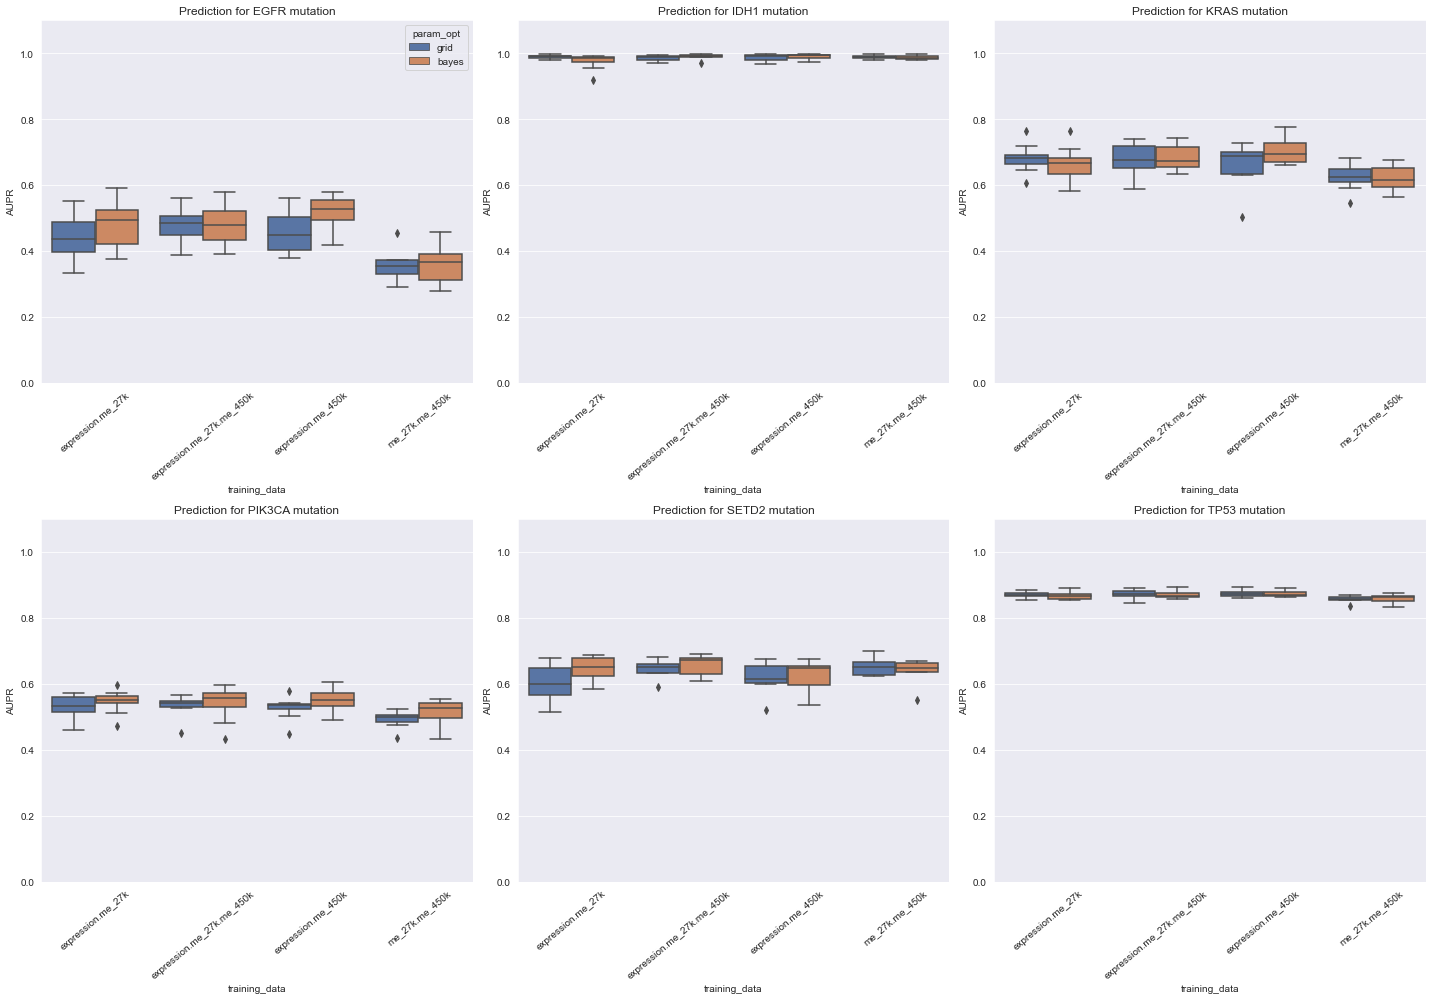

In [16]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 14)})
fig, axarr = plt.subplots(2, 3)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)

data_order =['expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

for ix, gene in enumerate(results_df.identifier.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.identifier == gene) &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
    sns.boxplot(data=plot_df, x='training_data', y='aupr',
                hue='param_opt', ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_ylabel('AUPR')
    ax.set_ylim(0.0, 1.1)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
    if ix != 0:
        ax.legend_.remove()
        
plt.tight_layout()